# Compute Rolling Standard Deviation, and Slope, and Output Thresholded Polygons

Import packages for plotting and working with spatial data:

In [1]:
import rasterio as rio
from rasterio import features
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
import geopandas as gpd
import pandas as pd
from rasterio.plot import plotting_extent

from geopandas import GeoDataFrame
from shapely.geometry import shape

Create a file path to your study area DEM .tif:

In [2]:
fn = 'data/TM_subset_final.tif'

Open your DEM using xarray:

In [3]:
im = xr.open_rasterio(fn)

Subset your image if it's too huge to work with the whole file:

In [4]:
#im_subset = im[:,0:511,0:511]

## Compute the Rolling Standard Deviation

In [5]:
# This function computes the rolling standard deviation within a square window of
# dimensions 'size' x 'size' and outputs a new array the standard deviation as the attribute values

def rolling_stdev(im, size):
    """
    Short Summary
    --------------------
    This function calculates the rolling standard deviation within a window of
    specified dimensions.
    
    Extended Summary
    ------------------
    This function utilizes xarray's rolling window operation to first create a 
    Rolling object, and then to apply that Rolling object to the DataArray
    to calculate standard deviation within each (size, size) window. The output is
    a new DataArray with each pixel populated with the standard deviation of all 
    pixels within the window for which the pixel was at the center. This function
    also outputs a plot of the output file for quick and easy data visualization.
    
    Parameters
    ------------
    im:   DataArray
            Generally a .tif file that has been loaded in using xarray.open_rasterio()
    size: 
            The dimension of the square rolling window to use. If one dimension is supplied, 
        it will be propagated to the proper number of dimensions. For example, a size
        set to 3 will generate a rolling window square of dimensions (3,3).
        
    Returns
    ------------
    DataArray
                consisting of the new xarray DataArray of standard deviation values
    """
    
    r = im.rolling(y=size)          # this creates the xarray Rolling object 
    im_stdev = r.reduce(np.std)     # this uses the rolling object to compute the standard deviation
    return im_stdev

In [6]:
# Implement the rolling standard deviation function on the image
# Use the magic timeit command if you want to compare the time this 
# function takes to another method

#%%timeit
stdev = rolling_stdev(im, 12)

In [7]:
# Get rid of the third dimension, which for a DEM should have a size of 1

stdev = stdev.squeeze()
stdev.shape

(5000, 5000)

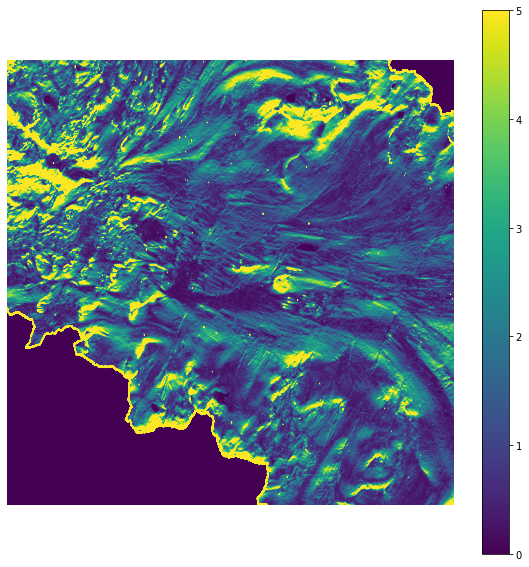

In [8]:
# Plot the results of the standard deviation function

fig, ax = plt.subplots(figsize=(10,10)) 
c=ax.imshow(stdev, vmin=0, vmax=5)           
ax.axis('off')
plt.colorbar(c)

## Threshold the Standard Deviation and Create Polygons from this Data

In [9]:
# Code in this cell is adapted from David Shean, supplied via Slack in March 2021
# This code masks the values of a raster above a certain value, 
# and outputs polygons for the masked and unmasked areas above a certain area threshold.

stdev_feat_list = []
ovr_scale = 5
src = rio.open(fn) 
x = stdev.coarsen(x=5).mean().coarsen(y=5).mean()
a = ma.masked_invalid(x, copy=True)
#a = stdev.read(1, masked=True, out_shape=(stdev.count, int(stdev.height / ovr_scale), int(stdev.width / ovr_scale)))
ovr_transform = src.transform * src.transform.scale(src.width / x.shape[-1], src.height / x.shape[-2])
b = ma.masked_where(a > 1, a)
mask = np.ma.getmaskarray(b).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
stdev_feat_list.extend([{'properties':{'stdev':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])
stdev_gdf = gpd.GeoDataFrame.from_features(stdev_feat_list, crs=src.crs)
#remove tiny polygons
area_thresh = 1e5
stdev_gdf = stdev_gdf.loc[stdev_gdf.area > area_thresh]
#Shoud simplify and sieve

Check out the output of the cell above. It is a geodataframe with polygons representing the masked area where the standard deviation is above the threshold.

In [10]:
stdev_gdf.head()

,geometry,stdev,date
280,"POLYGON ((288237.000 4202637.000, 288237.000 4...",data/TM_subset_final.tif,final
393,"POLYGON ((293307.000 4202592.000, 293307.000 4...",data/TM_subset_final.tif,final
440,"POLYGON ((290457.000 4202637.000, 290457.000 4...",data/TM_subset_final.tif,final
767,"POLYGON ((285612.000 4202142.000, 285612.000 4...",data/TM_subset_final.tif,final
985,"POLYGON ((287967.000 4202637.000, 287967.000 4...",data/TM_subset_final.tif,final


<AxesSubplot:>

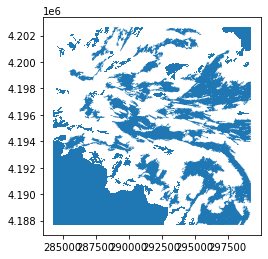

In [11]:
stdev_gdf.plot()

## Compute the Slope (or at least Load in the Data)

In [12]:
# Only run this cell is you don't already have a slope raster. 
# If you already have a slope raster, load it in in cells below.

# slope_fn = 'data/slope_final.tif'
# !gdaldem slope $fn $slope_fn

Create a filepath to your slope file:

In [15]:
slope_fn = '/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ImageAnalysis/data/slope_final.tif'

## Create Slope Threshold Polygons

Load in the slope file and mask the slope above a certain threshold, outputting another geodataframe with polygons representing areas where the slope is being masks.

In [16]:
# Code in this cell is from David Shean, supplied via Slack in March 2021
# This code masks the values of a raster above a certain value, 
# and outputs polygons for the masked and unmasked areas above a certain area threshold.

slp_feat_list = []
ovr_scale = 8
src1 = rio.open(slope_fn)
c = src1.read(1, masked=True, out_shape=(src1.count, int(src1.height / ovr_scale), int(src1.width / ovr_scale)))
c = ma.masked_invalid(c, copy=True)
ovr1_transform = src1.transform * src1.transform.scale(src1.width / c.shape[-1], src1.height / c.shape[-2])
d = ma.masked_where(c > 15, c)
mask1 = np.ma.getmaskarray(d).astype(np.uint8) - 1
shapes1 = features.shapes(mask1, mask=mask1, transform=ovr1_transform)
geom_list1 = list(shapes1)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
slp_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list1])
slp_gdf = gpd.GeoDataFrame.from_features(slp_feat_list, crs=src1.crs)
#remove tiny polygons
area_thresh = 1e5
slp_gdf = slp_gdf.loc[slp_gdf.area > area_thresh]
#Shoud simplify and sieve

Check out the output of the cell above. It is a geodataframe with polygons representing the masked area where the slope is above the threshold.

In [17]:
slp_gdf.head()

,geometry,fn,date
365,"POLYGON ((286455.000 4202523.000, 286455.000 4...",data/TM_subset_final.tif,final
499,"POLYGON ((294183.000 4202667.000, 294183.000 4...",data/TM_subset_final.tif,final
532,"POLYGON ((290991.000 4202667.000, 290991.000 4...",data/TM_subset_final.tif,final
793,"POLYGON ((284655.000 4202283.000, 284655.000 4...",data/TM_subset_final.tif,final
862,"POLYGON ((295359.000 4201875.000, 295359.000 4...",data/TM_subset_final.tif,final


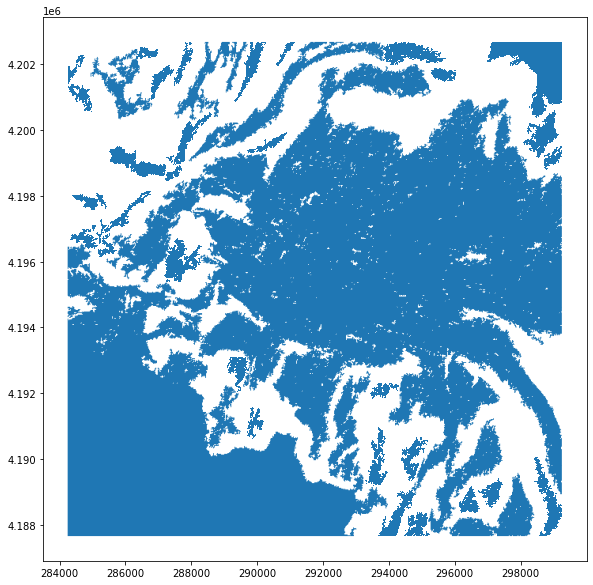

In [18]:
slp_gdf.plot(figsize=(10,10));

Plot both masks next to each other to compare and explore the data.

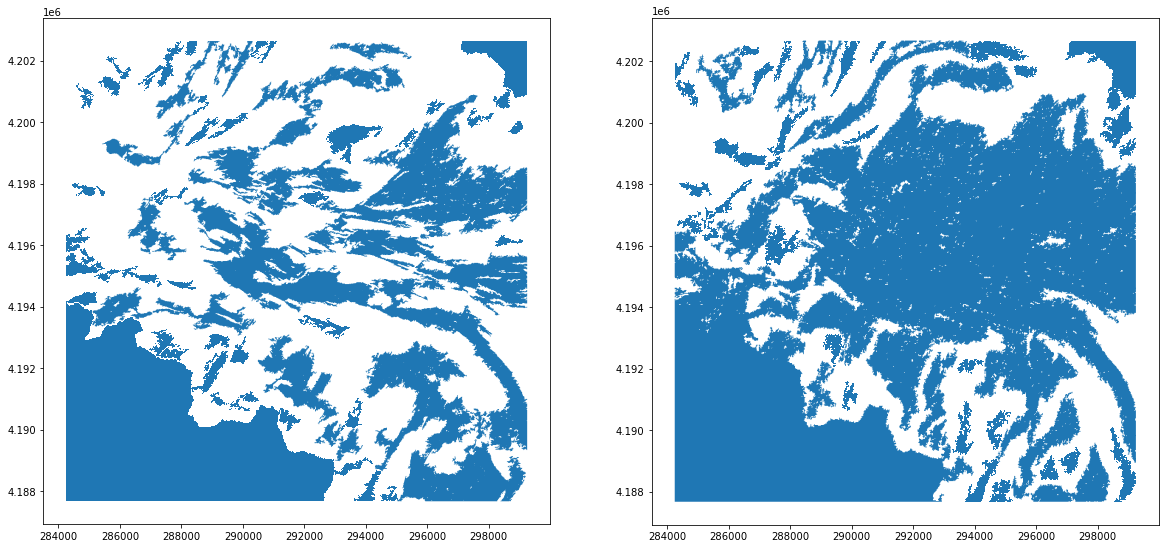

In [21]:
fig, ax = plt.subplots(ncols=2, figsize = (20, 10))

stdev_gdf.plot(ax=ax[0])
slp_gdf.plot(ax=ax[1]);

## Load in ICESat-2 Points (from the ATLAS instrument onboard the satellite) and Tuolumne Basin Outline

Load in the data to be clipped to the thresholded polygons. In our case, this is point elevation data that has been downloaded and preprocessed into a .csv file. Read it in as geodataframe with point geometry.

In [22]:
atlas_df = pd.read_csv('/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ICESat-2_Snowdepth/summer_2020_difference.csv')
atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))
tuol_basin = gpd.read_file('/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ImageAnalysis/data/Tuolumne_Boundary.geojson')

In [65]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ImageAnalysis


Plot the study area and the masks to make sure everything lines up as expected (projections should be the same).

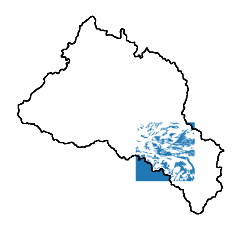

In [64]:
fig, ax = plt.subplots()
#atlas_gdf.plot(ax=ax)
stdev_gdf.plot(ax=ax)
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='black')
ax.axis('off')
plt.savefig('Tuol_with_stdev_area.jpeg')

## Buffer the Polygons to Make Sure They are Valid

Sometimes the polygons get read as invalid due to overlapping geometries. Buffer them by a small amount to remove any lines or overlapping vertices.

In [25]:
stdev_gdf['geometry'] = stdev_gdf.buffer(0.01)

In [26]:
slp_gdf['geometry'] = slp_gdf.buffer(0.01)

### Clip the ICESat-2 Points to the Slope and Standard Deviation Polygons

Now all that remains are elevation data that fall within areas that have slope less than our threshold and standard deviations less than our threshold. Hopefully, these data points are more accurate than the full spread of data points. 

In [27]:
atlas_gdf_clipped = gpd.clip(atlas_gdf, stdev_gdf, keep_geom_type=True)

In [28]:
atlas_gdf_clipped2 = gpd.clip(atlas_gdf_clipped, slp_gdf, keep_geom_type=True)

Now plot the results in a variety of ways to explore the results.

<AxesSubplot:>

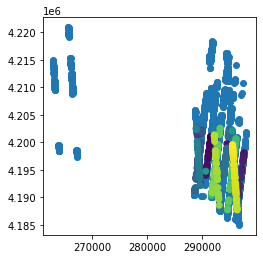

In [29]:
fig, ax = plt.subplots()

atlas_gdf.plot(ax=ax)
atlas_gdf_clipped.plot(cmap='viridis', ax=ax)

<AxesSubplot:>

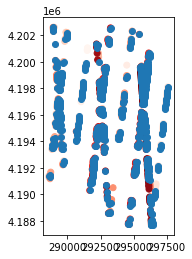

In [30]:
fig, ax = plt.subplots()

atlas_gdf_clipped.plot(cmap='Reds', ax=ax)
atlas_gdf_clipped2.plot(ax=ax)

<AxesSubplot:>

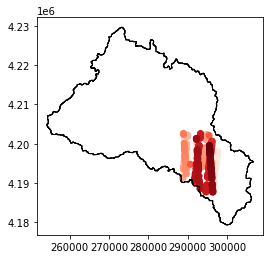

In [32]:
fig, ax = plt.subplots()
#atlas_gdf.plot(ax=ax)
atlas_gdf_clipped2.plot(ax=ax, cmap='Reds')
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='black')

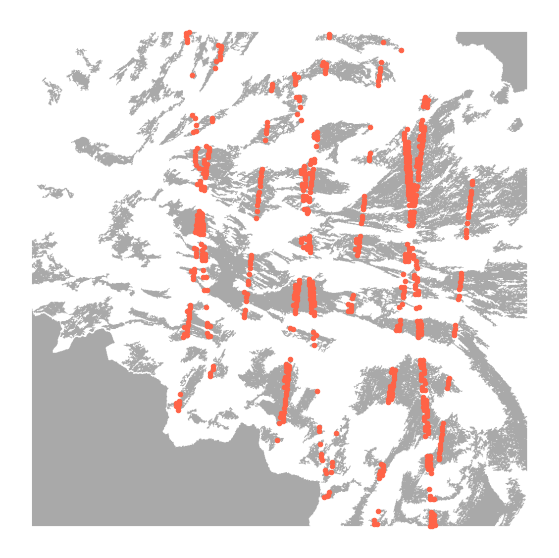

In [78]:
fig, ax = plt.subplots(figsize = (10,10))
stdev_gdf.plot(ax=ax, color='darkgrey')
atlas_gdf_clipped.plot(ax=ax, c='tomato', markersize=20)
ax.axis('off')
plt.savefig('stdev_mask_atlas_points.jpeg');

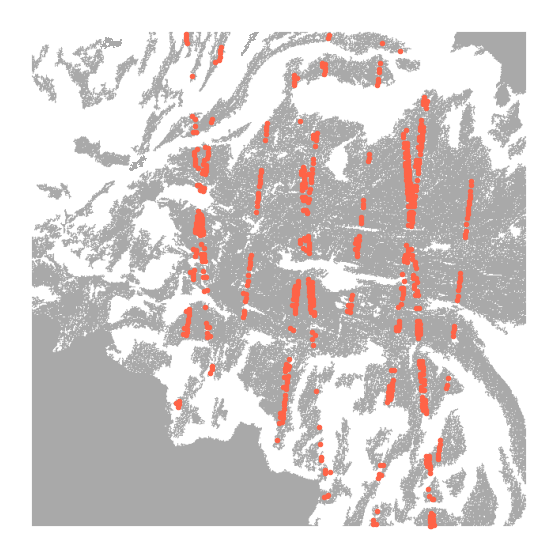

In [80]:
fig, ax = plt.subplots(figsize = (10,10))
slp_gdf.plot(ax=ax, color='darkgrey')
atlas_gdf_clipped2.plot(ax=ax, c='tomato', markersize=20)
ax.axis('off')
plt.savefig('slp_mask_atlas_points.jpeg');

<AxesSubplot:>

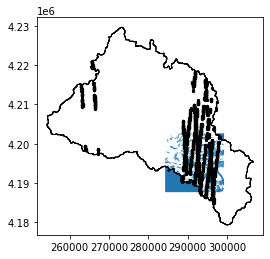

In [46]:
fig, ax = plt.subplots()
stdev_gdf.plot(ax=ax)
atlas_gdf.plot(ax=ax, c='k', markersize=5)
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='black')